<a href="https://colab.research.google.com/github/ramswaroopbhakar14/Upvotes-prediction/blob/master/Upvote_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
! git clone https://github.com/ramswaroopbhakar14/Upvotes-prediction.git

Cloning into 'Upvotes-prediction'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [12]:
%cd /content/Upvotes-prediction/data

/content/Upvotes-prediction/data


In [0]:
import pandas as pd
train_data = pd.read_csv('train_data.csv')

In [0]:
#df = train_data.iloc[:1000]
df = train_data.copy()

In [15]:
df.columns

Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')

In [0]:
"data pre-processing"
summary = df.describe()

"missing data summary"
summary_na= [df[x].isna().sum() for x in df.columns] # we don't have any nan values in this data

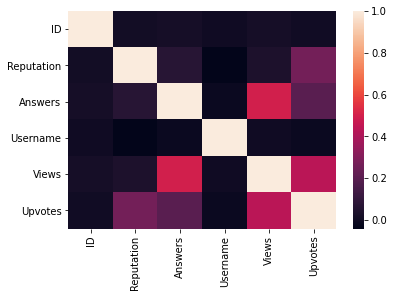

In [17]:
import seaborn as sns
"find correlation matrix"
df_corr = df.corr()

"generating heatmap using df_corr"
sns.heatmap(df_corr) # we don't see any var-pair haivng > 0.5 correlation, hence we'll be directly going for model building

In [0]:
"splitting train-test data"
from sklearn.model_selection import train_test_split

"Converting categorical str to continuous form usig dummy variables"
df1 = pd.concat([df.loc[:, df.columns!='Tag'], pd.get_dummies(df[['Tag']])], axis=1)

input_features = df1.drop(columns=['ID','Username', 'Upvotes']).values
target = df1['Upvotes'].values

X_train, X_val, y_train, y_val = train_test_split(input_features, target, random_state=10)


"ML models"
# we'll try 6 different models to get best model with best hyper-parameters
# will use gridsearchcv o randomizedsearchcv for parameter optimization
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLars
from xgboost import XGBRegressor
from sklearn.svm import SVR

poly5 = PolynomialFeatures(5)

llr = LassoLars()
knn = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgbr = XGBRegressor()
svr = SVR()

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

models = [llr, knn, svr, rfr, xgbr]
grid_params = {llr: {'alpha':[0,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10]},
                 knn:{'n_neighbors':[1,3,5,11,15,17,20,30,40,50,70],'weights':['uniform','distance'],'metric':['euclidean','manhattan']},
                 svr:{'C': [0.1, 1, 10, 100, 1000],'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                  rfr: {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],# Number of trees in random forest
                                                 'max_features': ['auto', 'sqrt',None],# Number of features to consider at every split
                                                 'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]+[None],# Maximum number of levels in tree
                                                 'min_samples_split': [2, 5, 10],# Minimum number of samples required to split a node
                                                 'min_samples_leaf': [1, 2, 4],# Minimum number of samples required at each leaf node
                                                 'bootstrap': [True, False]},# Method of selecting samples for training each tree
                 xgbr:{'eta':[0.1,0.3,0.5,0.7],'gamma':[0,10,100],'max_depth':[1,3,5,9,11]}}                                     


In [19]:
#%%
import time
scoring='neg_mean_squared_error'
cv_results_list = []
best_params_list = []
best_cv_rmse_list = []
val_rmse_list = []
train_time_list = []
for model in models[-1:]:
    num_iter = 20
    st = time.time()
#    model = GridSearchCV(knn, grid_params[knn], n_jobs=-1, scoring=scoring) # not performing gridsearchcv as it takes lot time
    total_param_combinations = np.prod([len(grid_params[model][par]) for par in list(grid_params[model].keys())])
    
    model = RandomizedSearchCV(estimator=model, n_iter=num_iter, cv=3, scoring=scoring,n_jobs=-1, param_distributions=grid_params[model], refit=True)
    
    if model==llr:
        X_train1 = poly5.fit_transform(X_train)
        model.fit(X_train1, y_train)
    else:
        model.fit(X_train, y_train)
    
    
    cv_results_list+=[model.cv_results_]
    
    best_cv_rmse1 = np.sqrt(-max(model.cv_results_['mean_test_score']))
    best_cv_rmse_list+=[best_cv_rmse1]
    
    best_params_list+=[model.best_params_]
    
    train_time1 = str(round(time.time()-st,2))+' seconds'
    train_time_list+=[train_time1]
    if model==llr:
        X_val1 = poly5.transform(X_val)
        y_pred = model.predict(X_val1)
    else:
        y_pred = model.predict(X_val)
    
    rmse1 = np.sqrt(mse(y_val,y_pred))
        
    val_rmse_list+=[rmse1]
    
    print('total_cv_time:',train_time1)
    print('avg_cv_rmse:',best_cv_rmse1)
    
    print('val_rmse:', rmse1)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[13:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
total_cv_time: 761.73 seconds
avg_cv_rmse: 1368.874132847604
val_rmse: 1596.463718322134


In [0]:
test_data = pd.read_csv('test_data.csv')

In [22]:
test_data.columns

Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views'], dtype='object')

In [23]:
test_data.head()

,ID,Tag,Reputation,Answers,Username,Views
0,366953,a,5645.0,3.0,50652,33200.0
1,71864,c,24511.0,6.0,37685,2730.0
2,141692,i,927.0,1.0,135293,21167.0
3,316833,i,21.0,6.0,166998,18528.0
4,440445,i,4475.0,10.0,53504,57240.0


In [0]:
"Converting categorical str to continuous form usig dummy variables"
test_data1 = pd.concat([test_data.loc[:, test_data.columns!='Tag'], pd.get_dummies(test_data[['Tag']])], axis=1)

test_inputs = test_data1.drop(columns=['ID','Username']).values

In [0]:
final_pred = model.predict(test_inputs)
final_submission = pd.DataFrame({'ID':list(test_data.ID),'Upvotes':list(final_pred)})

In [32]:
!git add -A

hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> data/Upvotes-prediction
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached data/Upvotes-prediction
hint: 
hint: See "git help submodule" for more information.


In [0]:
final_submission.to_csv(r'D:\Analytics vidhya\Predict number of upvotes\data\submission_xgbr_20.csv')

In [31]:
from google.colab import files
final_submission.to_csv('filename.csv') 
files.download('filename.csv')

MessageError: ignored